In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from config import config

In [3]:
# Get data from DB

params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()
cur.execute("select * from dataentry_cifnepal as CIF inner join dataentry_personboxnepal as PB on CIF.id = PB.cif_id;")
colnames = [desc[0] for desc in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns = colnames)
cur.close()

In [4]:
# Create Unique Suspect ID number

df['pb_number']=df['pb_number'].fillna(0).astype(int)
df['suspect_id'] = df['cif_number'].str.replace('.','')
df['suspect_id'] = df['suspect_id'].str[:-1] + ".PB" + df['pb_number'].map(str)
df = df.drop_duplicates(subset='suspect_id')
df.shape

(2255, 183)

In [5]:
#Remove columns that won't be used

df1 = df.drop(columns=['id','date_time_entered_into_system','status','location','date_time_last_updated','staff_name','informant_number',
                      'case_notes', 'pv_signed_form', 'consent_for_fundraising', 'guardian_name', 'guardian_phone', 'social_media', 
                      'permission_contact_pv', 'permission_contact_whats_app', 'permission_contact_facebook', 'permission_contact_phone', 
                      'legal_action_taken_filed_against', 'officer_name', 'cif_id', 'person_id', 'flag_count', 'main_pv_id', 
                       'expected_earning','expected_earning_currency','travel_expenses_paid_to_broker_amount', 'occupation',
                       'travel_expenses_broker_repaid_amount','form_entered_by_id', 'source_of_intelligence', 'date_time_last_updated',
                       'interview_date','incident_date','how_recruited_broker_other','legal_action_taken','legal_action_taken_case_type',
                       'appearance','date_visit_police_station','victim_statement_certified_date','pb_number','recruited_agency_pb',
                       'recruited_broker_pb','how_recruited_broker_online_pb','how_recruited_broker_approached_pb', 'known_broker_pb',
                       'expected_earning_pb','purpose_for_leaving_other','id_source_pb','exploitation_forced_prostitution_pb',
                       'exploitation_forced_prostitution_lb','exploitation_sexual_abuse_pb','exploitation_sexual_abuse_lb',
                       'exploitation_physical_abuse_pb','exploitation_physical_abuse_lb','exploitation_debt_bondage_pb',
                       'exploitation_debt_bondage_lb','exploitation_forced_labor_pb','exploitation_forced_labor_lb','associated_lb',
                       'exploitation_organ_removal_pb','exploitation_organ_removal_lb','exploitation_other_value','exploitation_other_pb',
                       'exploitation_other_lb','married_broker_pb','travel_expenses_paid_by_broker_pb','planned_destination',
                       'travel_expenses_paid_by_broker_repaid_pb','travel_expenses_paid_to_broker_pb','relation_to_pv','broker_relation',
                      ])
df1.shape

(2255, 110)

In [6]:
#Add Arrest data

Arrests = pd.read_csv("Arrests.csv")
df1 = pd.merge(df1, Arrests, how='outer',on='suspect_id', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('x', 'y'), copy=True, indicator=False,
         validate=None)
df1.Arrest=df1.Arrest.fillna('0').astype(int)
df1 = df1.dropna(axis=0, subset=['cif_number'])

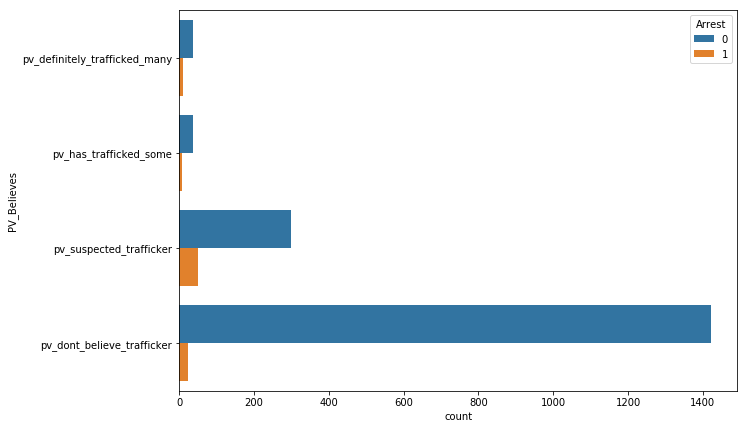

In [7]:
#Look at total arrests by "potential victim believes" response

df2 = df1[['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 'pv_suspected_trafficker', 'pv_dont_believe_trafficker', 'Arrest']]
df2 = pd.melt(df2, id_vars = ['Arrest'], value_vars = ['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 
                                                                   'pv_suspected_trafficker', 'pv_dont_believe_trafficker'],
                   var_name='PV_Believes', value_name='PV_BVal')
df2 = df2[df2.PV_BVal]

from matplotlib import pyplot

pdim=(10,7)
fig, ax = pyplot.subplots(figsize=pdim)
g = sns.countplot(ax=ax,y="PV_Believes", hue="Arrest",
                data=df2);

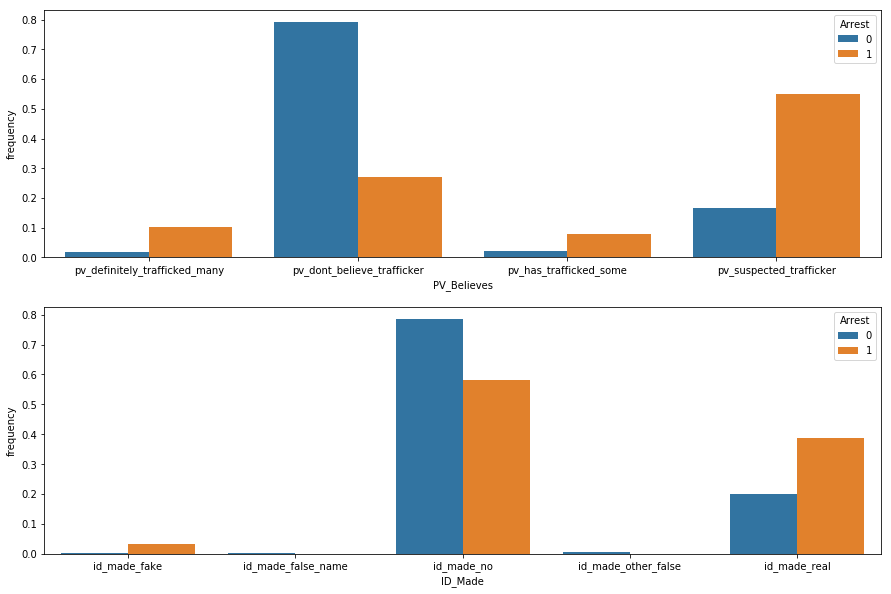

In [8]:
#Look at percentage of arrests by "potential victim believes" and "ID Made" responses

df3 = pd.melt(df1, id_vars =['Arrest'], value_vars =['id_made_no','id_made_real','id_made_fake','id_made_false_name','id_made_other_false'],
             var_name='ID_Made', value_name='ID_Val')
df3 = df3[df3.ID_Val]
df2 = df2.set_index(['Arrest', df2.groupby('Arrest').cumcount()])
df3 = df3.set_index(['Arrest', df3.groupby('Arrest').cumcount()])
df4 = (pd.concat([df2, df3],axis=1)
         .sort_index(level=1)
         .reset_index(level=1, drop=True)
         .reset_index())

fig, axes = plt.subplots(2,1, figsize=(15,10))

df4['frequency'] = 0
for col, ax in zip(['PV_Believes','ID_Made'], axes.flatten()):
    counts = df4.groupby([col,'Arrest']).count()
    freq_per_group = counts.div(counts.groupby('Arrest').transform('sum')).reset_index()
    sns.barplot(x=col,y='frequency', hue='Arrest',data=freq_per_group,ax=ax)

In [9]:
x_cols = [c for c in df if c not in ['Arrest','Arrest_Date','cif_number','suspect_id']]

numerical_features = ['number_of_victims','number_of_traffickers','known_broker_years', 'known_broker_months','married_broker_years', 
                'married_broker_months','reported_blue_flags','total_blue_flags','suspected_trafficker_count']

categorical_features = ['education','guardian_relationship','station_id','role']

boolean_features = list(
    set(list(df1.columns)) - set(numerical_features) - set(categorical_features))

df1[boolean_features] = df1[boolean_features].astype(bool)

df1[numerical_features] = df1[numerical_features].fillna(0).astype(float)

for f in categorical_features:
    df1[f] = df1[f].astype("category")

for cf in categorical_features:
    for elem in df1[cf].unique():
        df1[str(cf) + "_" + str(elem)] = df1[str(cf)] == elem
df1 = df1.drop(columns = categorical_features)

In [10]:
from sklearn.model_selection import train_test_split
X = (
    df1
    .drop(columns=['Arrest','Arrest_Date','cif_number','suspect_id'])
)
y = df1.Arrest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [12]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ]))
    ])),
])

In [13]:
from sklearn.linear_model import SGDClassifier

classifier_pipeline = make_pipeline(
    transformer,
    SGDClassifier()
)

In [16]:
classifier_pipeline.fit(X_train, y_train)
y_score = classifier_pipeline.decision_function(X_test)

C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


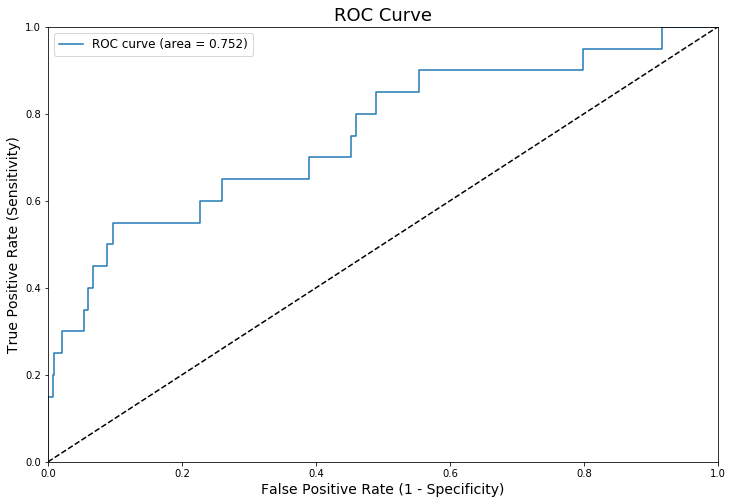

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curve', size=18)
plt.legend(fontsize=12);